In [1]:
#!pip install census
#!pip install us
## helpful packages
import pandas as pd
import numpy as np
import random
import re
import string
import requests
import plotnine 
from plotnine import *
import yaml

## note: you may need to install some of these using !pip install
## note that bitdotio has psycopg2 as a dependency so you'll need to either do:
## !pip install psycopg2 or !pip install psycopg2-binary
## see this issue for installation notes: https://github.com/rebeccajohnson88/PPOL564_slides_activities/issues/65
import census
from census import Census
import us
from us import states
import bitdotio
import warnings
warnings.filterwarnings("ignore")

## print mult things
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


def load_creds(path: str):
    with open(path, 'r') as stream:
        try:
            creds = yaml.safe_load(stream)
        except yaml.YAMLError as exc:
            print(exc)
    return(creds)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', None)



# Prep work: obtain an API key for the US Census (the American Community Survey)

- Obtain a census API key from here: https://api.census.gov/data/key_signup.html 
- Place it in a credentials yaml file that also contains the API key with the key for the database API (shared on Canvas)
- Documentation here for the `census` package on establishing an API connection: https://github.com/datamade/census

In [2]:

# Set up my cred.yml file

api_dict = {'class_database':{'api_key':'v2_3vN56_tTxihNw55pv9tBDtRZDmZcv'},'census_api':{'MY_API_KEY':'5f679ff2db51658a85bd3a834c94f5faebe94279'}}

with open('cred.yml', 'w') as yaml_file:
    yaml.dump(api_dict, yaml_file, default_flow_style=False)

In [3]:
## read creds file
creds = load_creds("cred.yml")


# APIs and SQL (50 points)

# 1. Write a wrapper function to pull data from the NAEP API (12 points)

In the class activity here: https://github.com/rebeccajohnson88/PPOL564_slides_activities/blob/main/activities/fall_22/solutions/10_apis_naep_yelp_solutions.ipynb

We practiced pulling from the API for the National Assessment of Educational Progress (NAEP), "America's report card" of test scores. We pulled a small amount of data at the national level (writing scores by gender) using a query where the parameters were hardcoded.
    
In this problem, we'll practice pulling a larger set of data at the state level and writing a wrapper function.
    
As a reminder, the documentation for the NAEP API is here: https://www.nationsreportcard.gov/api_documentation.aspx

The base link for writing queries is: https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx

## 1.1 Write a query to pull 8th-grade mathematics scores in 2015 from the state of California (CA) by gender (1 point)

- Subject: mathematics 
- Subscale: MRPCM composite scale 
- Grade: 8
- Year: 2015
- grouping variable: GENDER 
- Jurisdiction: CA 

Print the output in dataframe format and briefly interpret; what do scores look like between the genders?

In [4]:
# Write a query to pull 8-th grade mathematics scores in 2015 from the state of California by gender
math_15_naep_query = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015')


math_15_naep_query


'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'

In [5]:
## use requests to call the api
naep_15_resp = requests.get(math_15_naep_query)
naep_15_resp
print(type(naep_15_resp))

<Response [200]>

<class 'requests.models.Response'>


In [6]:
## get the json contents of the response 
naep_15_resp_j = naep_15_resp.json()

## with result, turn it into a dataframe
naep_15_resp_d = pd.DataFrame(naep_15_resp_j['result'])
naep_15_resp_d

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0


**Interpret:**

It seems that there is nearly no difference in scores between male and female in 2015 California. Female got a little bit higher than male.

## 1.2 Write a query to pull 8th-grade mathematics scores in 2013, 2015, 2017, and 2019 from California by gender (1 point)

Same as above but pull the years 2013, 2015, 2017, and 2019 (search documentation for how to pull multiple years in the same query) in one query

In [7]:
# Pull 8-th grade mathematics scores in 2013,2015,2017 and 2019 in just one query
math_13151719_naep_query = (
'https://www.nationsreportcard.gov/'
'Dataservice/GetAdhocData.aspx?'
'type=data&subject=mathematics&grade=8&'
'subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019')


math_13151719_naep_query

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'

In [8]:
## use requests to call the api
naep_13151719_resp = requests.get(math_13151719_naep_query)
naep_13151719_resp
print(type(naep_13151719_resp))

<Response [200]>

<class 'requests.models.Response'>


In [9]:
## get the json contents of the response 
naep_13151719_resp_j = naep_13151719_resp.json()

## with result, turn it into a dataframe
naep_13151719_resp_d = pd.DataFrame(naep_13151719_resp_j['result'])
naep_13151719_resp_d

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.721824,1,0


## 1.3 Create a line plot to show variation in the scores across years (2 points)

Using the results from 1.2, create a plot where the x axis has the year and the y axis is the math scores (`value` in dataframe), and there are separate lines/colors for male versus female students (`varValueLabel` in dataframe)

Start the limits of the y axis at 270  and add informative labels

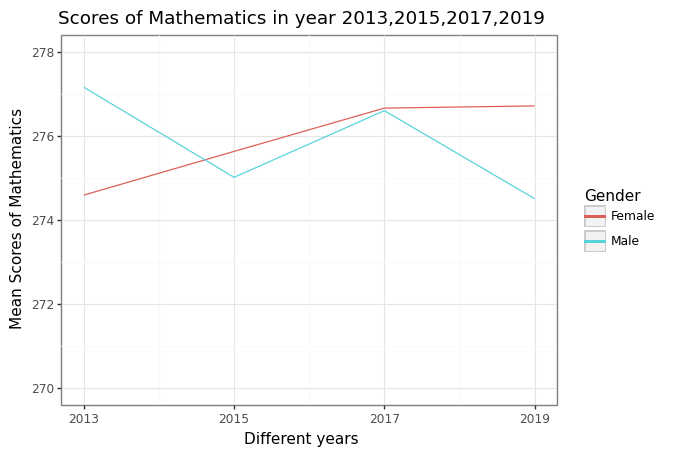

<ggplot: (8786370659554)>

In [10]:
# Create a line plot to show variation in the scores across years
(
    ggplot(naep_13151719_resp_d,aes(x='year',y='value',color='factor(varValueLabel)',group='varValueLabel'))
    +geom_line()
    +labs(
    x='Different years',
    y='Mean Scores of Mathematics',
    title='Scores of Mathematics in year 2013,2015,2017,2019'
    )
    +guides(color = guide_legend(title = 'Gender')) +
    theme_bw()
    +scale_y_continuous(limits=(270,278))
    +scale_x_continuous(breaks=(2013,2015,2017,2019))
    
)

## 1.4 Reproduce the queries from 1.1 and 1.2 using a user-defined function (4 points)

Create a function, `construct_naep_query` that takes in two arguments:

- year: this should be a list with all years (so if pulling one year, single element list; if multiple years, list with those years)
- place: this should be a string with the name of the state or jurisdiction to pull 
    
Have the function return the query and make sure it's identical to the queries you wrote for 1.1 and 1.2 (can use assert or other checker)

In [11]:
# Define function
def construct_naep_query(year,place):
    
    #Year 
    year_clps = ",".join(year)
    year_subq = 'Year=' + year_clps

    #Place 
    states_clps = ",".join(place)
    states_subq = 'jurisdiction=' + states_clps 
    
    ## first construct the query 
    query = (
    'https://www.nationsreportcard.gov/'
    'Dataservice/GetAdhocData.aspx?'
    'type=data&subject=mathematics&grade=8&'
    'subscale=MRPCM&variable=GENDER&'+states_subq+'&stattype=MN:MN&'+year_subq)
        
    return(query) 

In [12]:
# Execute function
year_list1=['2015']
year_list2=['2013','2015','2017','2019']
# Just for year 2015
query_2015=construct_naep_query(year_list1,['CA'])
query_2015
# For year 2013,2015,2017, and 2019
query_all=construct_naep_query(year_list2,['CA'])
query_all

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2015'

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=CA&stattype=MN:MN&Year=2013,2015,2017,2019'

## 1.5 Write and execute user-defined function that takes in a query and returns a pandas dataframe with the content of the response (4 points)

- Write a user-defined function (`process_naep_query`) that takes in the NAEP query as a string, calls the API, and transforms the response into a pandas dataframe. Have the function return that pandas dataframe

- Make sure the function is flexible enough to handle queries that return an error; for queries that return an error, have the function return the string "Data not found; check your query" (see solutions code for an example of try: except:)

- Execute the function on the query that pulls 2013, 2015, 2017, and 2019 data (either from handwriting the query or the result in 1.4)

- Print the resulting dataframe

- Then execute the function on a query that pulls a state that doesn't exist (call this state ZZ)

In [13]:
# Define the function 'process_naep_query'
def process_naep_query(naep_query):
    
    ## use requests to call
    resp = requests.get(naep_query)
    
    ## next, transform into json
    try:
        resp_j = resp.json()
        resp_df = pd.DataFrame(resp_j['result'])
        return(resp_df)
    except:
        print("Data not found; check your query")
        pass

In [14]:
# Execute function
# Just for year 2015
resp_df_2015=process_naep_query(query_2015)
resp_df_2015
# For year 2013,2015,2017, and 2019
resp_df_all=process_naep_query(query_all)
resp_df_all

,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
1,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0


,year,sample,yearSampleLabel,Cohort,CohortLabel,stattype,subject,grade,scale,jurisdiction,variable,variableLabel,varValue,varValueLabel,value,isStatDisplayable,errorFlag
0,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,277.167171,1,0
1,2013,R3,2013,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,274.597824,1,0
2,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,275.020977,1,0
3,2015,R3,2015,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,275.638637,1,0
4,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,276.608704,1,0
5,2017,R3,2017,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.669430,1,0
6,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,1,Male,274.511628,1,0
7,2019,R3,2019,2,Grade 8,MN:MN,MAT,8,MRPCM,CA,GENDER,Gender,2,Female,276.721824,1,0


In [15]:
# Wrong Query Test
Wrong_query=construct_naep_query(year_list1,['ZZ'])
Wrong_query

wrong_df=process_naep_query(Wrong_query)
wrong_df

'https://www.nationsreportcard.gov/Dataservice/GetAdhocData.aspx?type=data&subject=mathematics&grade=8&subscale=MRPCM&variable=GENDER&jurisdiction=ZZ&stattype=MN:MN&Year=2015'

Data not found; check your query


# 2. Explore data using SQL queries (22 points)

In the previous example, you worked with the data in a flat file and manipulated it using pandas. Here, we're going to practice running queries to do some calculations using SQL --- in the case of our data, this is a bit overkill since the data are small but it is practice for larger datasets.

- Database name: `rebeccajohnson88/ppol564_classdb`
- Table name: `math_gencompare`



## 2.0 Load a creds file (0 points)

Load a creds file that contains the two credentials you'll need for this and the next problem:

- The credentials for our class database
- The credentials for the Census API (see instructions above)

In [16]:
creds = load_creds("cred.yml")

## 2.1 Establish a connection to the database (1 point)

Note: if you get an error at this step, make sure you not only have bitdotio installed and imported but also its dependency psycopg2; we've also run into issues connecting on an unsecured (no password) wifi network so if you're on campus, try SaxaNet or eduroam

Note: for full credit, when initializing the bitdotio connection, make sure to use the API key from the creds file you read in eg:
`creds[class_database][api_key]` 

rather than hard-coding it in the code

In [17]:
# Connect to the database
b=bitdotio.bitdotio(creds['class_database']['api_key'])
cnx=b.get_connection("rebeccajohnson88/ppol564_classdb")

## 2.2 Run a query to select all columns and the first 5 rows of the data to explore structure (2 points)

Read the results in as a pandas dataframe and print the result

In [18]:
## define a query to pull first 5 rows
## from math_gencompare table
sample_case_q = """ select * 
from math_gencompare 
limit 5
"""

## feed read sql query the query
## and my database connection
read_sample_d = pd.read_sql_query(sample_case_q, cnx)
print(type(read_sample_d))
read_sample_d

<class 'pandas.core.frame.DataFrame'>


,abbrev,fips,state,year,female,male,is_male_higher
0,AL,1,Alabama,2017,266.748589,269.820070,1
1,AL,1,Alabama,2019,270.473059,267.093325,0
2,AR,5,Arkansas,2013,278.381788,277.457662,0
3,AR,5,Arkansas,2015,274.793326,275.325959,1
4,AR,5,Arkansas,2017,273.139254,274.352754,1


## 2.3 Find the (1) number of rows in the database, (2) number of distinct states,  (3) number of distinct years (3 points)

Interpret the results - how do you think the data is structured in terms of states and years (eg long format where each state repeated; wide format)?



In [19]:
math_gencompare_q=""" select * 
from math_gencompare
"""
math_gencompare_df=pd.read_sql_query(math_gencompare_q,cnx)
#math_gencompare_df
# (1)Find the number of rows in the database;
num_rows=len(math_gencompare_df)
num_rows
# (2)Find the number of distinct states;
num_distinct_states=math_gencompare_df.state.nunique()
num_distinct_states
# (3)Find the number of distinct years;
num_distinct_year=math_gencompare_df.year.nunique()
num_distinct_year

200

50

4

## 2.4 Construct a new variable in the table, `is_male_higher` that takes the value of 1 if the math scores of males exceed that of females in that state and year (each row) (2 points)

Read in the results, print the head, and find the mean across all rows (the percentage of state-years where male students have higher scores)

In [20]:
## There is already a column called is_male_higher in the database!

# Construct a new variable
math_man_higher_q="""
select * ,
CASE
    WHEN male>female THEN 1
    ELSE 0
END as is_male_higher_2
from math_gencompare
"""
math_man_higher_df=pd.read_sql_query(math_man_higher_q,cnx)

math_man_higher_df.head()

# Find the mean across all rows
male_higher=math_man_higher_df.is_male_higher.value_counts()
per_male_higher= male_higher/len(math_man_higher_df)

per_male_higher

,abbrev,fips,state,year,female,male,is_male_higher,is_male_higher_2
0,AL,1,Alabama,2017,266.748589,269.820070,1,1
1,AL,1,Alabama,2019,270.473059,267.093325,0,0
2,AR,5,Arkansas,2013,278.381788,277.457662,0,0
3,AR,5,Arkansas,2015,274.793326,275.325959,1,1
4,AR,5,Arkansas,2017,273.139254,274.352754,1,1


1    0.515
0    0.485
Name: is_male_higher, dtype: float64

## 2.5 group by year and find the percentage of states where male scores are higher than females (4 points)

**A.** Write a query that (1) groups by year and (2) finds the percentage of states for that year where males have higher scores than females 

**B.** Interpret the results 

Hint: can either use subquery to construct the `is_male_higher` and use it or do it all in one query with a comparison; the `avg` command is useful

In [21]:
# A.
group_year_q= """
select year,
avg(is_male_higher_2) as prop_male_higher
from math_gencompare
inner join (
    select state as STATE_,year as YEAR_,
CASE 
    WHEN male > female THEN 1
    ELSE 0
END as is_male_higher_2
from math_gencompare
    ) as tmp on tmp.STATE_ = math_gencompare.state and tmp.YEAR_=math_gencompare.year
group by year
order by prop_male_higher desc
"""

group_year_df=pd.read_sql_query(group_year_q,cnx)
group_year_df

,year,prop_male_higher
0,2013,0.62
1,2017,0.58
2,2015,0.56
3,2019,0.30


**Interpret the results**

In 2013, males had higher scores than females in mathematics in 62% of the states in the US. In 2015, males had higher scores than females in mathematics in 56% of the states in the US. In 2017, males had higher scores than females in mathematics in 58% of the states in the US. In 2019, males had higher scores than females in mathematics in 30% of the states in the US. We found that the gender gap in mathmetics scores has been decreasing over time.

## 2.5 group by state and find the percentage of years where male scores higher than females (4 points)

A. Write a query that (1) groups by state and (2) finds the percentage of years for that state where males have higher scores than females

B. Plot the results ordering the states from males higher all 4 years (prop = 1 or percent = 100%) to males higher none of the years

In [22]:
# A.
group_state_q= """
select state,
avg(cast(is_male_higher_2 as INTEGER)) as prop_male_higher
from math_gencompare
inner join (
    select state as STATE_,year as YEAR_,
CASE 
    WHEN male > female THEN 1
    ELSE 0
END as is_male_higher_2
from math_gencompare
    ) as tmp on tmp.STATE_ = math_gencompare.state and tmp.YEAR_=math_gencompare.year
group by state
order by prop_male_higher desc
"""

group_state_df=pd.read_sql_query(group_state_q,cnx)
group_state_df

,state,prop_male_higher
0,Illinois,1.00
1,Idaho,1.00
2,Utah,1.00
3,Colorado,0.75
4,Maine,0.75
5,Nevada,0.75
6,Alaska,0.75
7,West Virginia,0.75
8,Arizona,0.75
9,Washington,0.75


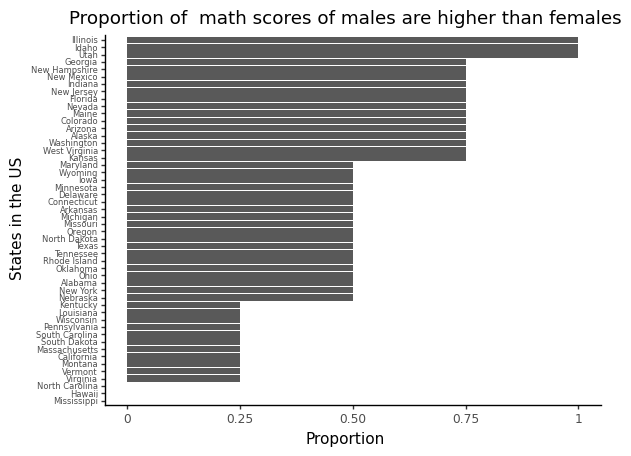

<ggplot: (8786345487044)>

In [23]:
## B.
# Plot the results ordering the states from males higher all 4 years (prop = 1 or percent = 100%)
# to males higher none of the years
(
    ggplot(group_state_df,aes(x='reorder(state,prop_male_higher)',y='prop_male_higher'))
          +geom_bar(stat = "identity", position = "dodge")
          +labs(
          x='States in the US',
          y='Proportion',
          title='Proportion of  math scores of males are higher than females')    
         +scale_y_continuous(breaks=(1,0.75,0.5,0.25,0))
         +coord_flip()
         +theme_classic() 
    +theme(axis_text_y = element_text(size = 6))

)

## 2.6 Use a subquery to create an indicator and group by that indicator (6 points)

The following states were the first 6 to expand the right to vote to women before the uniform federal expansion in 1920

- Wyoming 1890
- Colorado 1893
- Utah 1896
- Idaho 1896
- Washington 1910
- California 1911

**A.** Create an indicator `is_early_vote` for whether a state is in that list or not; do so without typing the state names inside the string and instead collapsing the list and using format. Hint you can use format and a joined list: https://stackoverflow.com/questions/12007686/join-a-list-of-strings-in-python-and-wrap-each-string-in-quotation-marks 

**B.** Then, group by that indicator and year and find the percencentage of states in each group where males had higher scores than females 

**C.** Read the results and interpret. Does early expansion of voting seem to be correlated with girls scoring bearing on the math tests a century later?

Hint: in order to group by the indicator in step b, you may need to use a subquery 

In [24]:
## we provide
list_voting = ["Wyoming", "Colorado", "Utah", "Idaho", "Washington", 
                "California"]

string=", ".join("'{0}'".format(w) for w in list_voting)
string

"'Wyoming', 'Colorado', 'Utah', 'Idaho', 'Washington', 'California'"

In [25]:
## A. Create an indicator 'is_early_vote'
## B. Group by the indicator and year

query_by_indicator = """
select is_early_vote, year, AVG(is_male_higher_2)
from math_gencompare
inner join
    (select fips as fips_id,
    year as year_id,
    CASE
        WHEN male > female
        THEN 1
        ELSE 0
    END as is_male_higher_2
    from math_gencompare) as math_gen_agg
    on math_gen_agg.fips_id = math_gencompare.fips and 
    math_gen_agg.year_id = math_gencompare.year
inner join
    (select fips as fips_id,
    year as year_id,
    CASE 
        WHEN state in ({})
        THEN 'Early'
        ELSE 'Non-early'
    END as is_early_vote
    from math_gencompare) as math_early_vote
    on math_early_vote.fips_id = math_gencompare.fips and 
    math_early_vote.year_id = math_gencompare.year
group by is_early_vote, year
order by is_early_vote, year
""".format(string)

In [26]:
## C. Read the results
early_vote_df=pd.read_sql_query(query_by_indicator,cnx)
early_vote_df

,is_early_vote,year,avg
0,Early,2013,0.833333
1,Early,2015,0.666667
2,Early,2017,0.833333
3,Early,2019,0.500000
4,Non-early,2013,0.590909
5,Non-early,2015,0.545455
6,Non-early,2017,0.545455
7,Non-early,2019,0.272727


**C. Interpret:**

Expanding the right to vote to women earlier seems to be not correlated with girls scoring bearing on the math tests a century later. Most men in the states which expand the right to vote to women still have higher math score than women.

# 3. Pull state-level attributes using Census API (8 points)

You want to explain the variation you see across states in gender gaps in test scores by looking at demographics of the state population. To do so, we'll pull demographics from the American Community Survey (ACS), a US Census data product discussed more here: https://en.wikipedia.org/wiki/American_Community_Survey

## 3.1 Obtain a Census API key, place it in credentials yaml, load the yaml file, and initialize connection to Census API using the `census` package  (0 points)



In [27]:
# Establishing an API connection
c=Census(creds['census_api']['MY_API_KEY'])
c.acs5.get(('NAME', 'B25034_010E'),
          {'for': 'state:{}'.format(states.MD.fips)})

print(type(c))

[{'NAME': 'Maryland', 'B25034_010E': 127820.0, 'state': '24'}]

<class 'census.core.Census'>


## 3.2 Run this function (feeding it your api connection) to get a list of variables to pull (0 points)

Feed the connection to the API you created in previous step (if you print type it's a census.core.Census class) to the `your_connection` argument in the function)

In [28]:
## keep in blank
to_pull = ['RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS',
          'ALLOCATION OF HOUSEHOLD INCOME IN THE PAST 12 MONTHS - PERCENT OF INCOME ALLOCATED',
          'MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2018 INFLATION-ADJUSTED DOLLARS)',
          'EDUCATIONAL ATTAINMENT FOR THE POPULATION 25 YEARS AND OVER',
          'HOUSEHOLD TYPE (INCLUDING LIVING ALONE) BY RELATIONSHIP']

In [29]:
## keep in blank
def get_acs_varnames(your_connection):
    
    ## get tables for the acs 5-year estimates
    all_tables = pd.DataFrame(your_connection.acs5.tables())
    
    ## specify the ones to pull
    info_topull = all_tables[all_tables.description.isin(to_pull)].copy()
    
    ## use raw api to get varnames within those tables
    all_vars = [pd.DataFrame(requests.get(one_table).json()['variables']).T
                for one_table in info_topull.variables]
    all_vars_df = pd.concat(all_vars)
    all_vars_df['varname'] = all_vars_df.index
    
    ## subset to relevant
    all_vars_df_subset = all_vars_df[['varname', 'group', 'label', 'concept']].copy()
    all_vars_df_est = all_vars_df_subset[all_vars_df.varname.str.contains("E$", 
                                        regex = True)].copy()
    return(all_vars_df_est)
    

In [30]:
acs_cols = get_acs_varnames(c)
acs_cols.head()

,varname,group,label,concept
B17026_003E,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_004E,B17026_004E,B17026,Estimate!!Total:!!.75 to .99,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_001E,B17026_001E,B17026,Estimate!!Total:,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_002E,B17026_002E,B17026,Estimate!!Total:!!Under .50,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
B17026_007E,B17026_007E,B17026,Estimate!!Total:!!1.50 to 1.74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS


## 3.3 Pull the variables for all 50 states (8 points)

**A.** Use list comprehension to pull these variables for every state (each FIPS code) using the `acs5.state` method for the year 2013.
- Hint: See the documentation for how to feed it variables to pull (requires a tuple); the documentation shows an example state--`MD`. You can find the other `FIPS` codes for states in the `states` object in `us` package you loaded above): https://github.com/datamade/census/blob/70e2c08710c1e10e5bc2054b78613fa8794d4765/README.rst

**B.** Transform the result (which is a list of jsons) into a list of dataframes. Then concatenate and melt (on state) into one long-format dataframe

**C.** First merge with the `all_states_fips` df, then merge that with `acs_cols` from 3.2 (on varname and variable) to know both which states the variables correspond to and the more informative variable names 

Call the final output `acs_df_forperc` so you can run the next code we provide

In [31]:
## run this code- keep in blank
## NOTE: you need to have the us package
## installed and imported
cols_pull = tuple(acs_cols.varname)
all_states = states.STATES
all_states_fips = pd.DataFrame({'FIPS':
                                [one_state.fips for one_state in all_states],
                               'state': [one_state.name for one_state in all_states],
                               'abbrev': [one_state.abbr for one_state in all_states]})
all_states_fips.head()

,FIPS,state,abbrev
0,01,Alabama,AL
1,02,Alaska,AK
2,04,Arizona,AZ
3,05,Arkansas,AR
4,06,California,CA


In [32]:
## A. Get the dataframe
acs_df_forperc = pd.DataFrame([c.acs5.state(cols_pull, state, year=2013)[0] for state in all_states_fips.FIPS])
acs_df_forperc.head()

,B17026_003E,B17026_004E,B17026_001E,B17026_002E,B17026_007E,B17026_009E,B17026_008E,B17026_005E,B17026_006E,B17026_011E,B17026_012E,B17026_010E,B17026_013E,B15003_025E,B15003_024E,B15003_023E,B15003_022E,B15003_021E,B15003_020E,B15003_003E,B15003_002E,B15003_001E,B15003_009E,B15003_007E,B15003_008E,B15003_006E,B15003_005E,B15003_004E,B15003_015E,B15003_014E,B15003_013E,B15003_012E,B15003_011E,B15003_010E,B15003_018E,B15003_019E,B15003_017E,B15003_016E,B99192_008E,B99192_004E,B99192_005E,B99192_006E,B99192_007E,B99192_001E,B99192_002E,B99192_003E,B09019_003E,B09019_004E,B09019_001E,GEO_ID,state,B09019_002E,B09019_008E,B09019_007E,B09019_009E,B09019_005E,B09019_006E,B09019_025E,B09019_026E,B09019_023E,B09019_024E,B09019_021E,B09019_022E,B09019_015E,B09019_016E,B09019_013E,B09019_014E,B09019_011E,B09019_012E,B09019_010E,B09019_017E,B09019_019E,B09019_018E,B09019_020E
0,50074.0,53859.0,1241686.0,74205.0,58909.0,34795.0,23922.0,57371.0,59138.0,176601.0,133526.0,215664.0,303622.0,30801.0,45646.0,187852.0,458393.0,236473.0,511830.0,221.0,40711.0,3193338.0,9373.0,6968.0,5580.0,2916.0,1397.0,469.0,111838.0,108517.0,79804.0,55034.0,28317.0,29685.0,173415.0,191413.0,818315.0,58370.0,280886.0,37211.0,31292.0,49157.0,86001.0,1838683.0,1299320.0,54816.0,3968636.0,1241686.0,4799277.0,0400000US01,01,4683880.0,1418049.0,882621.0,1311169.0,677527.0,564159.0,596997.0,270981.0,20372.0,715244.0,31307.0,3557.0,10651.0,17999.0,55042.0,45055.0,71426.0,147657.0,35454.0,75588.0,5575.0,74288.0,13477.0
1,3056.0,3970.0,169367.0,4573.0,5766.0,3684.0,2177.0,4650.0,5237.0,23575.0,21451.0,22626.0,68602.0,5068.0,7431.0,31988.0,80447.0,36351.0,96565.0,62.0,2796.0,454301.0,901.0,959.0,855.0,367.0,224.0,86.0,8279.0,6590.0,3995.0,4425.0,1129.0,2049.0,22792.0,34397.0,101267.0,5278.0,17068.0,8580.0,5723.0,6954.0,21156.0,251899.0,189671.0,2747.0,584125.0,169367.0,720316.0,0400000US02,02,693856.0,223837.0,126316.0,203010.0,90234.0,79133.0,82532.0,45967.0,6753.0,109731.0,9444.0,907.0,2191.0,2770.0,7824.0,5143.0,11285.0,15118.0,9542.0,9802.0,1373.0,21757.0,3280.0
2,55487.0,60186.0,1563121.0,86949.0,70294.0,43075.0,26588.0,66633.0,72359.0,218403.0,166271.0,266637.0,430239.0,48203.0,69819.0,296979.0,716734.0,350503.0,776231.0,266.0,52419.0,4211194.0,14975.0,15501.0,11498.0,6889.0,3826.0,919.0,98332.0,81666.0,72185.0,67010.0,19843.0,74635.0,168804.0,318274.0,863210.0,82473.0,384033.0,45804.0,40274.0,61707.0,108160.0,2370289.0,1669437.0,60874.0,5286113.0,1563121.0,6479703.0,0400000US04,04,6335998.0,1928352.0,1138765.0,1797830.0,885541.0,677580.0,807168.0,392580.0,44816.0,1049885.0,73396.0,5276.0,20416.0,28675.0,88206.0,84983.0,82031.0,165257.0,48491.0,106187.0,11511.0,162151.0,27152.0
3,31249.0,35931.0,762881.0,43029.0,41711.0,23047.0,16129.0,38031.0,42131.0,110009.0,77756.0,140896.0,162962.0,15503.0,23201.0,93456.0,257157.0,119038.0,304123.0,119.0,22954.0,1936554.0,6426.0,5284.0,5182.0,2436.0,974.0,284.0,65281.0,56755.0,41721.0,39489.0,15410.0,19453.0,117797.0,129676.0,561542.0,33293.0,155502.0,23151.0,21194.0,30287.0,52880.0,1129723.0,817271.0,29438.0,2407262.0,762881.0,2933369.0,0400000US05,05,2852772.0,839575.0,560761.0,770442.0,420102.0,342779.0,366842.0,170516.0,15716.0,445510.0,23605.0,2296.0,5750.0,11008.0,28303.0,26963.0,46293.0,75895.0,22840.0,42827.0,4083.0,53299.0,7599.0
4,292341.0,335736.0,8603822.0,401978.0,379180.0,212130.0,139331.0,373991.0,393913.0,1037021.0,834096.0,1278538.0,2925567.0,360357.0,565907.0,1821325.0,4753446.0,1895918.0,3972174.0,4672.0,598141.0,24455010.0,156411.0,181967.0,124002.0,95574.0,38883.0,8610.0,539423.0,402112.0,520250.0,328269.0,142259.0,822708.0,540940.0,1432568.0,4525094.0,624000.0,1629632.0,317601.0,285821.0,422695.0,722139.0,12542460.0,8830224.0,334348.0,31476624.0,8603822.0,37659181.0,0400000US06,06,36843355.0,11869789.0,6163628.0,11259355.0,4852887.0,3750935.0,3938638.0,1860601.0,282760.0,5366731.0,410446.0,28189.0,186082.0,237522.0,680465.0,730904.0,388727.0,920567.0,221707.0,960495.0,164748.0,1123350.0,237207.0


In [33]:
## B. Concatenate and melt (on state) into one long-format dataframe
acs_df_forperc = pd.melt(acs_df_forperc, 
                         id_vars = ['GEO_ID', 'state'], 
                         value_vars = [col 
                                       for col in list(acs_df_forperc.columns) 
                                       if col not in ['GEO_ID', 'state']])

In [34]:
## C. First merge with the all_states_fips df, then merge that with acs_cols
acs_df_forperc = acs_df_forperc.merge(all_states_fips, how = 'left', 
                                      left_on = 'state', right_on='FIPS', 
                                      suffixes=('_df_forperc', '_fips'))

acs_df_forperc = acs_df_forperc.merge(acs_cols, how = 'left', 
                                      left_on = 'variable', right_on='varname', 
                                      suffixes=('_df_forperc', '_acs_cols'))

In [35]:
acs_df_forperc=acs_df_forperc[['variable','value','FIPS','state_fips','abbrev','varname','group','label','concept']]
acs_df_forperc=acs_df_forperc.rename(columns={'state_fips':'state'})
acs_df_forperc.head()

,variable,value,FIPS,state,abbrev,varname,group,label,concept
0,B17026_003E,50074.0,01,Alabama,AL,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
1,B17026_003E,3056.0,02,Alaska,AK,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
2,B17026_003E,55487.0,04,Arizona,AZ,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
3,B17026_003E,31249.0,05,Arkansas,AR,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS
4,B17026_003E,292341.0,06,California,CA,B17026_003E,B17026,Estimate!!Total:!!.50 to .74,RATIO OF INCOME TO POVERTY LEVEL OF FAMILIES IN THE PAST 12 MONTHS


## 3.4 run code to transform counts into percentages (0 points)

- Run the following code to transform the ACS counts in `acs_df_forperc` into percentages

Note: You may see a warning from the str.split step; feel free to ignore it


In [36]:
def create_percentages(df, name_estimatecol = 'estimate'):
    
    ## remove cols that dont need percentages
    df_forperc = df[~df.perc_NA].copy()
    
    ## group by location and variable prefix 
    group_co_tract_varg = df_forperc.groupby(['FIPS', 'variable_prefix'])
    
    ## iterate over groups
    df_longperc = []
    for group, data_raw in group_co_tract_varg:
        prefix = data_raw.variable_prefix.iloc[0]
        FIPS = data_raw.FIPS.iloc[0]
        row_list_group = []
        data = data_raw.sort_values(by = 'variable_suffix')
        for i in range(1, data.shape[0]):
            numerator = data[name_estimatecol].iloc[i]
            denominator = float(data[name_estimatecol].iloc[0])
            if denominator == 0:
                denominator = np.nan
            if denominator != 0:
                percentage = numerator / denominator
                row = [prefix, FIPS]
                row = row + [data.variable_suffix.iloc[i], percentage]
                row_list_group.append(row)
        df_longperc.append(pd.DataFrame(row_list_group))
    percentages_all_groups = pd.concat(df_longperc)
    percentages_all_groups.columns = ['variable_prefix',"FIPS",
                                  'variable_suffix', 'percentage']
    percentages_all_groups['percentage'] = percentages_all_groups.percentage.astype(float)
    return(percentages_all_groups)



In [37]:
varnames_percnotrelevant = ["B19013_001E"]

## create prefix and suffix columns
acs_df_forperc['variable_prefix'], acs_df_forperc['variable_suffix'] = \
                                acs_df_forperc['varname'].str.split('_', 1).str
acs_df_forperc['perc_NA'] = np.where(acs_df_forperc.varname.isin(varnames_percnotrelevant),
                                  True, False)
acs_df_forperc = acs_df_forperc[acs_df_forperc.variable != "GEO_ID"].copy()

perc_long = create_percentages(acs_df_forperc, 'value').sort_values(by = 'variable_prefix')

In [38]:
perc_long_wnames = pd.merge(perc_long,
                           acs_df_forperc,
                           on = ['variable_prefix', 'variable_suffix', 'FIPS'],
                           how = "right")
perc_long_wnames['value'] = perc_long_wnames.value.astype(float)

perc_long_wnames['percentage'] = np.where(perc_long_wnames.perc_NA,
                                         perc_long_wnames.value,
                                         perc_long_wnames.percentage)
perc_long_wnames['varname_words'] = "acspredict_" + perc_long_wnames.concept.str.replace("\s+|\(|\)", "_", 
                                    regex = True).str.lower() + \
                            perc_long_wnames.label.str.replace("\.|\!|\,|\(|\)|\-", 
                                    "", regex = True).str.lower() 

perc_long_wnames_final = perc_long_wnames[['FIPS', 'percentage', 
                                          'varname_words']].copy()


perc_wide = pd.pivot_table(perc_long_wnames_final, 
                           index = 'FIPS',
                          columns='varname_words',
                            values='percentage').reset_index()

## merge state info back on
perc_wide_wstate = pd.merge(perc_wide,
                           all_states_fips,
                           on = "FIPS",
                           how = "left")


In [39]:
perc_wide_wstate.head()

,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:associate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:bachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:doctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:ged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:kindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:master's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:no schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:nursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:professional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:regular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:some college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:some college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in households:,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in household

## 3.5 extra credit (2 points)

Use list comprehension and NAEP query creation/process results functions you created above to iterate over state abbreviations in `all_states_fips` and pull the same test score gap information

If skipping, you'll read in pkl at next step

**Note**: this took 2 mins to run on my machine

In [40]:
#Create a list out of the all_states_fips abbreviation
abb_list = list(all_states_fips.abbrev)

math_states_df = process_naep_query(construct_naep_query(['2013','2015','2017','2019'], 
                                                         place=abb_list))

#Print the math_states_df 
math_states_df = math_states_df[['year', 'jurisdiction', 'varValueLabel', 'value']].copy()
math_states_df

,year,jurisdiction,varValueLabel,value
0,2013,AK,Male,281.723376
1,2013,AK,Female,281.388243
2,2013,AL,Male,269.457456
3,2013,AL,Female,268.920112
4,2013,AR,Male,277.457662
5,2013,AR,Female,278.381788
6,2013,AZ,Male,280.174389
7,2013,AZ,Female,279.249581
8,2013,CA,Male,277.167171
9,2013,CA,Female,274.597824


In [41]:
# Rename the columns 
math_states_df = math_states_df.rename(columns={'jurisdiction':'abbrev'})

# Reshape the data - gender to different columns
math_states_wide = math_states_df.pivot(index=['abbrev', 'year'], 
                                        columns = 'varValueLabel', 
                                        values = 'value').reset_index()
math_states_wide

varValueLabel,abbrev,year,Female,Male
0,AK,2013,281.388243,281.723376
1,AK,2015,280.879362,280.143705
2,AK,2017,276.557200,277.451445
3,AK,2019,271.915723,276.639877
4,AL,2013,268.920112,269.457456
5,AL,2015,266.810672,266.304405
6,AL,2017,266.748589,269.820070
7,AL,2019,270.473059,267.093325
8,AR,2013,278.381788,277.457662
9,AR,2015,274.793326,275.325959


In [42]:
# Reshape the data - year to diff columns 
math_states_wide = math_states_wide.pivot(index=['abbrev'], 
                                          columns = ['year'], 
                                          values = ['Female', 'Male'])

math_states_wide

# Rename the columns
math_states_wide.columns = [col[0].lower() + "_" + str(col[1]) 
                            for col in list(math_states_wide.columns)]

# Reset index in the wide df
math_states_wide = math_states_wide.reset_index()
math_states_wide

Female                                            Male                                    
year          2013        2015        2017        2019        2013        2015        2017        2019
abbrev                                                                                                
AK      281.388243  280.879362  276.557200  271.915723  281.723376  280.143705  277.451445  276.639877
AL      268.920112  266.810672  266.748589  270.473059  269.457456  266.304405  269.820070  267.093325
AR      278.381788  274.793326  273.139254  276.007484  277.457662  275.325959  274.352754  272.827299
AZ      279.249581  282.593875  279.935438  280.527631  280.174389  283.229891  284.522633  279.359156
CA      274.597824  275.638637  276.669430  276.721824  277.167171  275.020977  276.608704  274.511628
CO      289.923675  283.898503  286.168864  283.911518  289.454320  287.171109  286.323452  285.385576
CT      285.001719  283.393821  284.606768  286.782984  285.474592  284.487781  283.692085  285.549408
DE      280.819272  279.596346  278.486818  277.011790  283.830455  280.014330  277.569065  276.395872
FL      280.041721  275.868331  277.121862  278.453322  281.654866  274.807349  281.050252  278.591887
GA      278.897697  278.710518  280.214908  280.118063  279.446739  278.713068  281.833220  278.901916
HI      283.519308  282.028307  279.449541  275.571667  279.503381  276.629680  275.372806  275.108594
IA      284.381733  285.466521  286.718969  281.815519  285.734439  287.383299  285.778031  281.533327
ID      285.831705  283.599653  283.469365  283.676750  286.976906  283.877251  285.222879  288.042802
IL      284.751037  281.869448  278.701228  281.889739  285.037468  282.063553  284.371999  283.206368
IN      287.306602  286.771233  288.324142  285.354234  288.213645  287.557591  287.089449  285.929852
KS      288.733125  283.913516  282.806156  280.976436  290.261606  283.831639  287.662841  283.390442
KY      280.282609  279.373347  279.746712  280.077223  280.989580  276.602014  275.765731  276.167365
LA      272.914362  269.469773  265.769454  273.126862  272.610984  267.379344  267.202356  270.244521
MA      300.230890  298.737677  297.946866  296.228245  300.904212  295.067817  296.146152  292.763614
MD      286.894080  284.568973  280.121328  280.070338  286.397218  281.741423  281.668535  280.217199
ME      287.042353  284.483843  284.110466  282.133861  290.310425  285.245819  283.900507  282.587468
MI      280.579895  276.708813  279.340918  280.653652  279.713426  279.552654  279.661916  279.929823
MN      293.775600  294.451781  293.751661  292.441654  295.404318  293.846605  294.169732  289.240414
MO      283.332222  279.391401  280.030623  280.830901  282.657909  282.217192  281.160796  280.699843
MS      271.214224  272.599570  270.936798  274.721176  271.109404  268.638854  270.893799  272.753306
MT      289.414157  285.909843  285.868230  284.650839  289.053257  288.949056  285.346629  283.277048
NC      285.830669  281.934351  282.408158  285.980551  285.466840  280.752718  281.467349  281.395063
ND      290.218517  288.167890  288.201713  285.771801  290.802638  288.317529  288.144147  285.373280
NE      285.259674  286.486328  287.307207  285.840504  284.871870  286.510743  289.445056  284.208990
NH      296.126425  293.326322  292.073515  286.045484  295.229753  295.460234  294.430496  288.349632
NJ      296.932719  293.046540  290.790484  291.679816  295.223058  293.666532  292.584235  291.961792
NM      272.767820  269.754712  268.318925  268.456051  272.756076  272.016591  270.427933  269.064177
NV      277.441711  274.973936  274.862712  274.339622  279.090456  275.359614  275.843416  273.278607
NY      283.336573  279.752036  282.030852  279.731183  280.379929  280.412289  281.357468  281.052937
OH      289.044420  285.883718  287.530652  286.846124  289.993062  284.289634  287.891518  284.623398
OK      276.191859  273.725109  274.976093  275.504107  274.832878  275.429953  274.411983  277.40

,abbrev,female_2013,female_2015,female_2017,female_2019,male_2013,male_2015,male_2017,male_2019
0,AK,281.388243,280.879362,276.557200,271.915723,281.723376,280.143705,277.451445,276.639877
1,AL,268.920112,266.810672,266.748589,270.473059,269.457456,266.304405,269.820070,267.093325
2,AR,278.381788,274.793326,273.139254,276.007484,277.457662,275.325959,274.352754,272.827299
3,AZ,279.249581,282.593875,279.935438,280.527631,280.174389,283.229891,284.522633,279.359156
4,CA,274.597824,275.638637,276.669430,276.721824,277.167171,275.020977,276.608704,274.511628
5,CO,289.923675,283.898503,286.168864,283.911518,289.454320,287.171109,286.323452,285.385576
6,CT,285.001719,283.393821,284.606768,286.782984,285.474592,284.487781,283.692085,285.549408
7,DE,280.819272,279.596346,278.486818,277.011790,283.830455,280.014330,277.569065,276.395872
8,FL,280.041721,275.868331,277.121862,278.453322,281.654866,274.807349,281.050252,278.591887
9,GA,278.897697,278.710518,280.214908,280.118063,279.446739,278.713068,281.833220,278.901916


In [43]:
# Obtain the fips code for each states
math_states_wide = math_states_wide.merge(all_states_fips, 
                                          how = 'left', 
                                          left_on = 'abbrev', 
                                          right_on = 'abbrev')

# Merge with the perc_wide_wstate dataset on FIPS code 
acs_wmath = math_states_wide.merge(perc_wide_wstate, 
                                   how = 'left', 
                                   left_on = ['FIPS', 'abbrev', 'state'], 
                                   right_on = ['FIPS', 'abbrev', 'state'])

# 4. Explore variation in math score disparities and trends (8 points)

## 4.0 If you didn't complete the extra credit, read in the `acs_wmath.pkl` file (csv is backup) (0 points)

In [44]:
## See th data
acs_wmath.head()

,abbrev,female_2013,female_2015,female_2017,female_2019,male_2013,male_2015,male_2017,male_2019,FIPS,state,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:associate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:bachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:doctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:ged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:kindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:master's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:no schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:nursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:professional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:regular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:some college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal:some college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetotal:in hou

## 4.1 Create a visualization where one axis is the state; the other axis is the male 2013 math scores - the female 2013 math scores (gender disparity) (2 points)


You have free rein over additional details but make sure it is informative over what direction of disparity positive versus negative values mean


In [45]:
acs_wmath['dis_gen_2013']=acs_wmath['male_2013']-acs_wmath['female_2013']


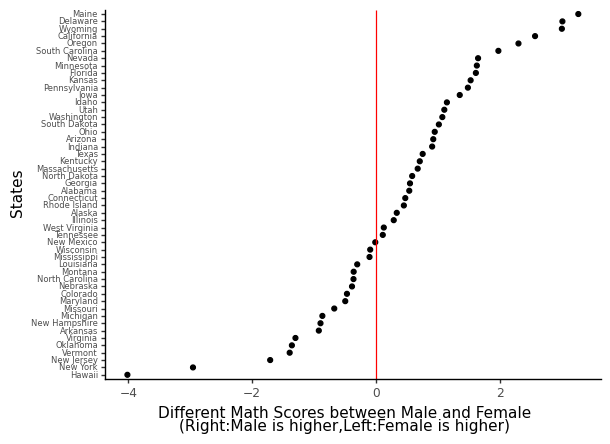

<ggplot: (8786362281301)>

In [46]:
## Create a visualization
(
ggplot(acs_wmath,aes(x='reorder(state,dis_gen_2013)',y='dis_gen_2013'))
    +geom_point()
    +coord_flip()
    +theme_classic()
    +theme(axis_text_y=element_text(size=6))
    +geom_hline(yintercept=0,color='red')
    +labs(x='States',
         y='Different Math Scores between Male and Female\n(Right:Male is higher,Left:Female is higher)')
)

## 4.2 Examine gender disparity in relation to household income (6 points)

**A.** Construct an indicator variable for the state having better performance of males in 2013 than females

**B.** First plot a smoothed scatterplot of estimated median household income from the acs data (we provide varname below) vs `math_male_2013`. Then do a second smoothed scatterplot for median household income vs `math_female_2013`.

**C.** 
Then use the `np.corrcoef` command (three separate times) to examine the bivariate correlation of
- male performance
- female performance
- the indicator variable from **A** 

with median household income (`acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars`)

Documentation: https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

**D.** Interpret the correlations:
   - Do boys in states with higher median household income (MHI) tend to perform better than boys in states with lower MHI?
   - Do girls in states with higher MHI tend to perform better than girls in states with lower MHI?
   - Is the male performance advantage over girls higher or lower in states with higher MHI?

In [47]:
acs_wmath_new=pd.read_csv("acs_wmath.csv")
acs_wmath_new.head()

,math_female_2013,math_female_2015,math_female_2017,math_female_2019,math_male_2013,math_male_2015,math_male_2017,math_male_2019,abbrev,FIPS,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 10 to less than 25 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 25 to less than 50 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated 50 to less than 100 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated dollar value of zero allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated more than 0 to less than 10 percent of total income for household allocated,acspredict_allocation_of_household_income_in_the_past_12_months_-_percent_of_income_allocatedestimatepercent of income allocated no income allocated,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal10th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal11th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal12th grade no diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal1st grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal2nd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal3rd grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal4th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal5th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal6th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal7th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal8th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotal9th grade,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalassociate's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalbachelor's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotaldoctorate degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalged or alternative credential,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalkindergarten,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalmaster's degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalno schooling completed,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalnursery school,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalprofessional school degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalregular high school diploma,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college 1 or more years no degree,acspredict_educational_attainment_for_the_population_25_years_and_overestimatetotalsome college less than 1 year,acspredict_household_type__including_living_alone__by_relationshipestimatetotalin group quarters,acspredict_household_type__including_living_alone__by_relationshipestimatetot

In [48]:
## A. Construct an indicator variable for the state having better performance of males in 2013 than females
acs_wmath_new['is_male_higher_2013']=np.where(acs_wmath_new.math_male_2013>acs_wmath_new.math_female_2013,True,False)


In [49]:
## Rename the column
acs_wmath_new=acs_wmath_new.rename(columns={'acspredict_median_household_income_in_the_past_12_months__in_2018_inflation-adjusted_dollars_estimatemedian household income in the past 12 months in 2018 inflationadjusted dollars':'median_income_2018'})

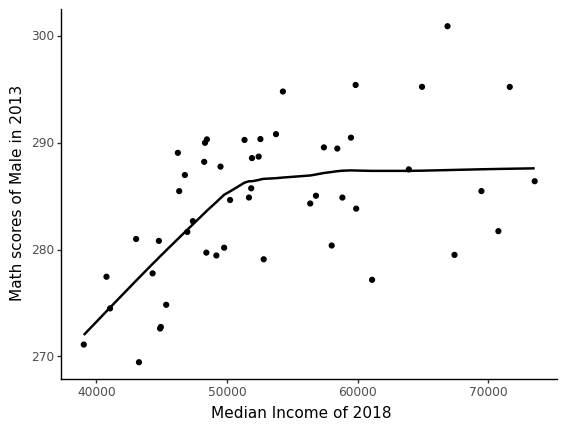

<ggplot: (8786345491128)>

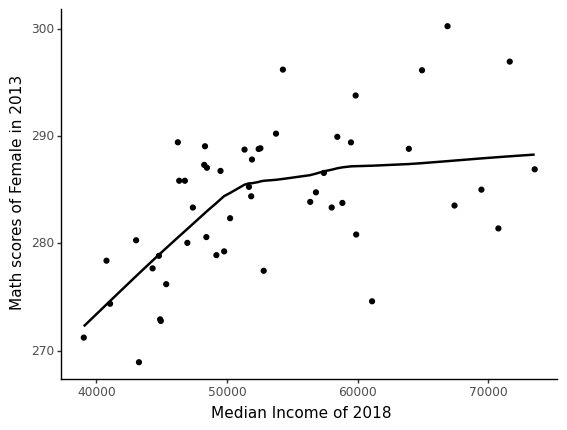

<ggplot: (8786409327839)>

In [50]:
## B. Plot a smoothed scatterplot of estimated median household income vs math_male_2013. 
##.   Then do a second smoothed scatterplot for median household income vs math_female_2013.

# Male
(
ggplot(acs_wmath_new,aes(x='median_income_2018',y='math_male_2013'))
    +geom_point()
    +geom_smooth()
    +labs(x='Median Income of 2018',
         y='Math scores of Male in 2013')
    +theme_classic()
)

# Female
(
ggplot(acs_wmath_new,aes(x='median_income_2018',y='math_female_2013'))
    +geom_point()
    +geom_smooth()
    +labs(x='Median Income of 2018',
         y='Math scores of Female in 2013')
    +theme_classic()
)

In [51]:
## C.Use the np.corrcoef command (three separate times) to examine the bivariate correlation of
array_malescore=np.array(acs_wmath_new.math_male_2013)
array_femalescore=np.array(acs_wmath_new.math_female_2013)
array_indicator=np.array(acs_wmath_new.is_male_higher_2013)
array_houseincome=np.array(acs_wmath_new.median_income_2018)
#male performance 
print("Correlation between Male Math Score and Median Household Income:")
np.corrcoef(array_malescore,array_houseincome)
#female performance
print("Correlation between Female Math Score and Median Household Income:")
np.corrcoef(array_femalescore,array_houseincome)
#the indicator variable(is_male_higher_2013)
print("Correlation between Indicator and Median Household Income:")
np.corrcoef(array_indicator,array_houseincome)

Correlation between Male Math Score and Median Household Income:


array([[1.        , 0.50734719],
       [0.50734719, 1.        ]])

Correlation between Female Math Score and Median Household Income:


array([[1.        , 0.54337803],
       [0.54337803, 1.        ]])

Correlation between Indicator and Median Household Income:


array([[ 1.       , -0.0338752],
       [-0.0338752,  1.       ]])

**D.** Interpret the correlations:
   - Do boys in states with higher median household income (MHI) tend to perform better than boys in states with lower MHI?
   - Do girls in states with higher MHI tend to perform better than girls in states with lower MHI?
   - Is the male performance advantage over girls higher or lower in states with higher MHI?

1. The first scatterplot: **boys in states with higher median household income tend to perform better than boys in states with lower household income, but only until a certain point of income**. 

2. The second scatterplot: **girls in states with higher median household income tend to perform relatively better than girls in states with lower household income, also only until a certain point of income**. And,the correlation matrix also shows that female math scores have stronger association with median household income than boys math scores.

3. The correlation matrix shows a negative correlation between the indicator and the median household incomes,which means **as median household incomes increase, boys' performance advantage over girls will diminish.**